In [ ]:
# !kaggle datasets download -d nih-chest-xrays/data

In [1]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:15<00:00, 199MB/s]
100% 2.29G/2.29G [00:15<00:00, 164MB/s]


In [2]:
!unzip chest-xray-pneumonia.zip -d chest-xray-pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0442-

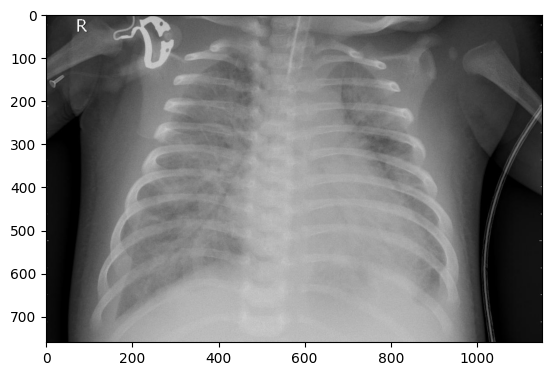

In [3]:
import matplotlib.pyplot as plt
import cv2 as cv

img1 = cv.imread('/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg')

plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.show()

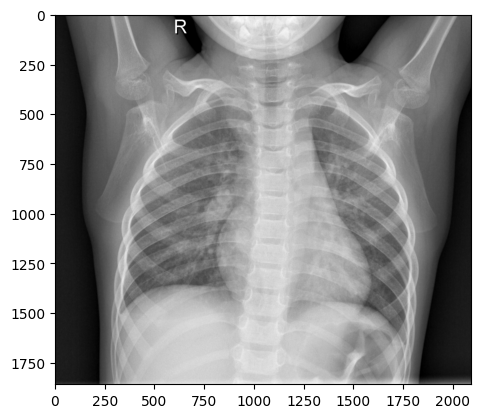

In [4]:
img2 = cv.imread('/content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg')
plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
plt.show()

In [5]:
import os
from PIL import Image

image_dir = '/content/chest-xray-pneumonia/chest_xray/test'  # Replace with your image directory

# List to store problematic files
corrupted_files = []
unsupported_format_files = []

# Supported formats
supported_formats = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')

# Iterate over all files in the directory
for root, dirs, files in os.walk(image_dir):
    for file in files:
        file_path = os.path.join(root, file)
        # Check file extension
        if file.lower().endswith(supported_formats):
            try:
                # Attempt to open the image file
                with Image.open(file_path) as img:
                    # Verify that it is, in fact, an image
                    img.verify()
            except (IOError, SyntaxError) as e:
                print(f"Corrupted image file detected: {file_path}")
                corrupted_files.append(file_path)
            except Exception as e:
                print(f"Unexpected error with file {file_path}: {e}")
                corrupted_files.append(file_path)
        else:
            print(f"Unsupported image format: {file_path}")
            unsupported_format_files.append(file_path)


In [21]:
import torch
from torchvision.transforms import v2

data_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(20),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [22]:
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_mapping = {'NORMAL': 0, 'PNEUMONIA': 1}
        supported_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')

        # Iterate over each class folder in the image directory
        for label_name in os.listdir(self.image_dir):
            label_dir = os.path.join(self.image_dir, label_name)
            if os.path.isdir(label_dir):
                # Iterate over each image in the class folder
                for img_name in os.listdir(label_dir):
                    img_path = os.path.join(label_dir, img_name)
                    if os.path.isfile(img_path) and img_name.lower().endswith(supported_extensions):
                        self.images.append(img_path)
                        self.labels.append(self.label_mapping[label_name])
                    else:
                        print(f"Skipping non-image file: {img_path}")
            else:
                print(f"Skipping non-directory entry: {label_dir}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            label = label  # If you need it as a tensor: torch.tensor(label, dtype=torch.long)
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None

In [23]:
train_dataset = CustomDataset('/content/chest-xray-pneumonia/chest_xray/train', transform=data_transforms)
val_dataset = CustomDataset('/content/chest-xray-pneumonia/chest_xray/val', transform=data_transforms)
test_dataset = CustomDataset('/content/chest-xray-pneumonia/chest_xray/test', transform=data_transforms)

In [24]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [25]:
import torch.nn as nn
from torchvision import models

# Load DenseNet-121 pre-trained on ImageNet (you can replace with a model pre-trained on CheXNet)
model = models.densenet121(pretrained=True)

# Freeze all layers to retain pretrained weights
for param in model.parameters():
    param.requires_grad = False

# Customize the final fully connected layers
num_ftrs = model.classifier.in_features  # DenseNet-121 output features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 128),  # Add a fully connected layer with 128 units
    nn.ReLU(),
    nn.Linear(128, 32),        # Another fully connected layer with 32 units
    nn.ReLU(),
    nn.Linear(32, 2)           # Output layer for 2 classes (e.g., Pneumonia vs Normal)
)

# Now the model is ready to be fine-tuned for your dataset


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 171MB/s]


In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
# model.load_state_dict(torch.load('medcam-model-50.pth'))

In [31]:
num_epochs = 25
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_loss += loss.item() * inputs.size(0)

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct / total

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            # Accumulate validation loss
            val_running_loss += val_loss.item() * val_inputs.size(0)

            # Calculate validation accuracy
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    # Calculate average validation loss and accuracy
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_accuracy = 100 * val_correct / val_total

    # Print statistics for this epoch
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')



Epoch 1/25, Train Loss: 0.3784, Train Accuracy: 84.91%, Val Loss: 0.5336, Val Accuracy: 68.75%
Epoch 2/25, Train Loss: 0.2011, Train Accuracy: 91.93%, Val Loss: 0.6900, Val Accuracy: 68.75%
Epoch 3/25, Train Loss: 0.1855, Train Accuracy: 92.79%, Val Loss: 0.6504, Val Accuracy: 75.00%
Epoch 4/25, Train Loss: 0.1821, Train Accuracy: 92.56%, Val Loss: 0.4635, Val Accuracy: 75.00%
Epoch 5/25, Train Loss: 0.1672, Train Accuracy: 93.27%, Val Loss: 0.3329, Val Accuracy: 87.50%
Epoch 6/25, Train Loss: 0.1843, Train Accuracy: 93.12%, Val Loss: 0.2353, Val Accuracy: 87.50%
Epoch 7/25, Train Loss: 0.1714, Train Accuracy: 93.35%, Val Loss: 0.4615, Val Accuracy: 68.75%
Epoch 8/25, Train Loss: 0.1851, Train Accuracy: 92.68%, Val Loss: 0.7988, Val Accuracy: 62.50%
Epoch 9/25, Train Loss: 0.1707, Train Accuracy: 93.44%, Val Loss: 0.8084, Val Accuracy: 68.75%
Epoch 10/25, Train Loss: 0.1593, Train Accuracy: 93.73%, Val Loss: 0.2610, Val Accuracy: 81.25%
Epoch 11/25, Train Loss: 0.1535, Train Accuracy: 

In [33]:
torch.save(model.state_dict(), 'medcam-model-75.pth')

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score

model.eval()
total = 0
correct = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store all labels and predictions for precision, recall, and F1 calculation
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Accuracy calculation
accuracy = 100 * correct / total

# Precision, Recall, and F1-Score calculation
precision = precision_score(all_labels, all_predictions, average='binary')  # for binary classification
recall = recall_score(all_labels, all_predictions, average='binary')
f1 = f1_score(all_labels, all_predictions, average='binary')

print(f'Test Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')


Test Accuracy: 83.49%
Precision: 0.79
Recall: 0.99
F1-Score: 0.88


In [34]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-w2jy5qdq
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-w2jy5qdq
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 18144f2afc8a14a73e71b68dc7fbdb7378af2f8e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.2-py3-none-any.whl size=38146 sha256=8f7e90b3c0bdd437f03827329204f1c858dd85cb5977fdd9935b71bcd938246b
  Stored in directory: /tmp/pip-ephem-wheel-cache-c5fy7o9v/wheels/23/11/66/71a38b0c29ba4ec5f62105a2145278613855bc9c94eecf630d
Successfully built grad-cam


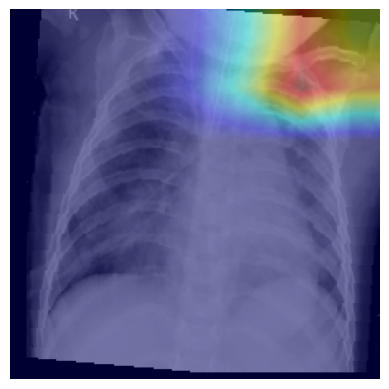

In [36]:
# Import necessary libraries
import torch
from torchvision import transforms
from pytorch_grad_cam import GradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
import cv2  # OpenCV for image processing

# Assuming 'model' is your DenseNet model
model.eval()
model.to(device)

# Define the target layers for DenseNet-121
target_layers = [model.features[-1]]  # For DenseNet models, use the last layer in 'features'

# Initialize CAM method (EigenCAM in this case)
cam_method = EigenCAM  # Use EigenCAM
cam = cam_method(model=model, target_layers=target_layers)

# Prepare your input image
# Assuming 'inputs' is your input tensor of shape [batch_size, channels, height, width]
# Let's use the first image in the batch
input_tensor = inputs[7:8].to(device)  # Select the first image and keep batch dimension

# Generate the CAM
grayscale_cam = cam(input_tensor=input_tensor)
grayscale_cam = grayscale_cam[0]  # Remove batch dimension

# Denormalize the input image for visualization
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1).to(device)
    img_tensor = img_tensor * std + mean
    return img_tensor

# Get the input image as a NumPy array
input_image = denormalize(input_tensor[0]).cpu().numpy()
input_image = np.transpose(input_image, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
input_image = np.clip(input_image, 0, 1)

# Convert the grayscale CAM to RGB
grayscale_cam_uint8 = np.uint8(255 * grayscale_cam)
heatmap = cv2.applyColorMap(grayscale_cam_uint8, cv2.COLORMAP_JET)

# Convert input_image to BGR format (as OpenCV uses BGR)
input_image_bgr = cv2.cvtColor((input_image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(heatmap, 0.4, input_image_bgr, 0.6, 0)

# Convert back to RGB for displaying with Matplotlib
superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(superimposed_img_rgb)
plt.axis('off')
plt.show()


Predicted Class: Pneumonia
Probability of Pneumonia: 0.9996


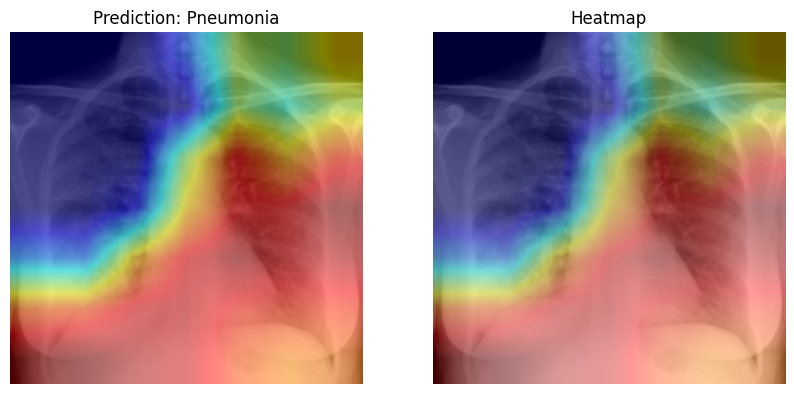

In [40]:
import torch
import torchvision.transforms.v2 as v2  # v2 transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Assuming 'model' is your DenseNet model
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Updated data augmentation transforms with v2 API
transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(20),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.ToImage(),  # For v2 API to ensure image compatibility
    v2.ToDtype(torch.float32, scale=True),  # Equivalent of ToTensor()
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to process the input image in real-time
def process_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = model(input_tensor)

    # Apply softmax to get probabilities for both classes
    probabilities = torch.nn.functional.softmax(output, dim=1)
    probability, prediction = torch.max(probabilities, 1)  # Get the class with highest probability

    class_names = ['Normal', 'Pneumonia']
    predicted_class = class_names[prediction.item()]
    print(f'Predicted Class: {predicted_class}')
    print(f'Probability of Pneumonia: {probabilities[0][1].item():.4f}')  # Probability of Pneumonia

    # Generate CAM
    target_layers = [model.features[-1]]  # For DenseNet
    cam = EigenCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor)[0]

    # Prepare the original image for visualization
    rgb_image = np.array(image.resize((224, 224))) / 255.0
    if rgb_image.shape[2] == 4:  # Handle alpha channel if present
        rgb_image = rgb_image[:, :, :3]

    # Overlay CAM on the image
    visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

    # Generate heatmap
    grayscale_cam_uint8 = np.uint8(255 * grayscale_cam)
    heatmap = cv2.applyColorMap(grayscale_cam_uint8, cv2.COLORMAP_JET)
    rgb_image_uint8 = np.uint8(255 * rgb_image)
    bgr_image = cv2.cvtColor(rgb_image_uint8, cv2.COLOR_RGB2BGR)
    superimposed_img = cv2.addWeighted(heatmap, 0.4, bgr_image, 0.6, 0)
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    # Display the results
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(visualization)
    plt.title(f'Prediction: {predicted_class}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img_rgb)
    plt.title('Heatmap')
    plt.axis('off')

    plt.show()

# Example usage for real-time image processing
image_path = '/content/Pneumonia.jpeg'  # Replace with actual image path
process_image(image_path)
